# **BREAST CANCER SURVIVAL STATUS PREDICTION NOTEBOOK**

## **Summary**

1. Importing libraries and data
2. Data cleaning and preparation
3. Data transformation function
4. Training: first models
5. Training: hyperparameters tuning
6. Model finalization
7. Test on unseen data

.

.

## **1. Importing libraries and data**

In [46]:
#Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import skew
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

In [47]:
#Importing data
Data = pd.read_csv("analitics_hub_tcga_output.csv")
Data

,Patient ID,Definition,Tumour Stage,Survival Status,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype
0,TCGA-3C-AAAU,primary solid tumor,X,alive,female,premenopausal,white,55.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumA
1,TCGA-3C-AALI,primary solid tumor,2b,alive,female,postmenopausal,black or african american,50.0,positive,positive,positive,NaN,NaN,infiltrating ductal carcinoma,Basal
2,TCGA-3C-AALJ,primary solid tumor,2b,alive,female,postmenopausal,black or african american,NaN,positive,positive,indeterminate,NaN,NaN,infiltrating ductal carcinoma,Basal
3,TCGA-3C-AALK,primary solid tumor,1a,alive,female,unknown,black or african american,NaN,positive,positive,positive,NaN,NaN,infiltrating ductal carcinoma,LumA
4,TCGA-4H-AAAK,primary solid tumor,3a,alive,female,postmenopausal,white,50.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,Her2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,TCGA-WT-AB44,primary solid tumor,1a,alive,female,postmenopausal,white,77.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,Basal
1201,TCGA-XX-A899,primary solid tumor,3a,alive,female,postmenopausal,white,46.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumA
1202,TCGA-XX-A89A,primary solid tumor,2b,alive,female,postmenopausal,white,68.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumB
1203,TCGA-Z7-A8R5,primary solid tumor,3a,alive,female,postmenopausal,white,61.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumA


In [48]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient ID         1205 non-null   object 
 1   Definition         1205 non-null   object 
 2   Tumour Stage       1193 non-null   object 
 3   Survival Status    1205 non-null   object 
 4   Gender             1205 non-null   object 
 5   Menopausal Status  1203 non-null   object 
 6   Race               1205 non-null   object 
 7   Age                1200 non-null   float64
 8   ER                 1092 non-null   object 
 9   PR                 1092 non-null   object 
 10  HER2               1086 non-null   object 
 11  Lymph Node         776 non-null    object 
 12  Metastasis         771 non-null    object 
 13  Histological Type  1203 non-null   object 
 14  Subtype            1093 non-null   object 
dtypes: float64(1), object(14)
memory usage: 141.3+ KB


In [49]:
#Almost all categories are "object" some missing values are present
Data.isna().sum()

Patient ID             0
Definition             0
Tumour Stage          12
Survival Status        0
Gender                 0
Menopausal Status      2
Race                   0
Age                    5
ER                   113
PR                   113
HER2                 119
Lymph Node           429
Metastasis           434
Histological Type      2
Subtype              112
dtype: int64

In [50]:
#So there several features with missing values. For some of those, a common imputation method (i.e. mean/median/mode) is not appropriate 
#given that each patient has his/her own data. Some alternative options are:
#   - Remove all NaN values (this will reduce the dataset)
#   - Set those values to 0 (meaning that the measure is absent or unknown)



#Creation of a Training set and a Test set 
#The Test set will be 3% (36 samples)
X_train, X_test, y_train, y_test = train_test_split(Data.drop(["Survival Status"],axis=1),
                                                    Data["Survival Status"], 
                                                    test_size = 0.03, random_state = 0)

X_train

,Patient ID,Definition,Tumour Stage,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype
141,TCGA-A7-A13G,primary solid tumor,2a,female,postmenopausal,white,79.0,positive,positive,negative,absent,absent,infiltrating lobular carcinoma,Basal
541,TCGA-BH-A0B4,primary solid tumor,3a,male,not available,white,65.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,LumA
851,TCGA-D8-A1XW,primary solid tumor,2a,female,postmenopausal,white,53.0,negative,positive,negative,absent,absent,infiltrating ductal carcinoma,LumA
487,TCGA-B6-A0IO,primary solid tumor,2a,female,indeterminate,white,66.0,positive,indeterminate,not evaluated,absent,absent,infiltrating ductal carcinoma,LumA
412,TCGA-AR-A0TZ,primary solid tumor,NaN,female,premenopausal,white,43.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,Basal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,TCGA-E9-A22G,primary solid tumor,2a,female,postmenopausal,white,47.0,negative,negative,positive,absent,absent,infiltrating ductal carcinoma,LumA
763,TCGA-C8-A12X,primary solid tumor,2b,female,postmenopausal,asian,62.0,positive,positive,negative,present,absent,mucinous carcinoma,LumB
835,TCGA-D8-A1XB,primary solid tumor,2b,female,postmenopausal,white,62.0,positive,positive,negative,present,absent,infiltrating ductal carcinoma,LumA
559,TCGA-BH-A0BL,primary solid tumor,1,female,premenopausal,white,35.0,negative,negative,negative,absent,absent,infiltrating ductal carcinoma,LumA


.

.

## **2. Data cleaning and preparation**

In [51]:
#Info about the Training set data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient ID         1168 non-null   object 
 1   Definition         1168 non-null   object 
 2   Tumour Stage       1156 non-null   object 
 3   Gender             1168 non-null   object 
 4   Menopausal Status  1166 non-null   object 
 5   Race               1168 non-null   object 
 6   Age                1164 non-null   float64
 7   ER                 1059 non-null   object 
 8   PR                 1059 non-null   object 
 9   HER2               1054 non-null   object 
 10  Lymph Node         751 non-null    object 
 11  Metastasis         747 non-null    object 
 12  Histological Type  1166 non-null   object 
 13  Subtype            1060 non-null   object 
dtypes: float64(1), object(13)
memory usage: 136.9+ KB


In [52]:
#First, let's take a look at the "Patient_ID" column
#The name is made of three parts:
#  - The first part is the acronym for "The Cancer Genome Atlas" (TCGA)
#  - The second one refers to a particular type of cancer (there are 830 different types)
#  - The third one is a code related to the patient

#Creation of a series with the 830 different types of cancer.
#This will be used later
#(from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tissue-source-site-codes)
TSS = ["1","2","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","1Z","20","21","22","23","24","25","26","27","28","29","2A",
       "2E","2F","2G","2H","2J","2K","2L","2M","2N","2P","2V","2W","2X","2Y","2Z","30","31","32","33","34","35","36","37","38","39","3A","3B","3C","3E",
       "3G","3H","3J","3K","3L","3M","3N","3P","3Q","3R","3S","3T","3U","3W","3X","3Z","41","42","43","44","46","49","4A","4B","4C","4D","4E","4G","4H",
       "4J","4K","4L","4N","4P","4Q","4R","4S","4T","4V","4W","4X","4Y","4Z","50","51","52","53","55","56","57","58","59","5A","5B","5C","5D","5F","5G",
       "5H","5J","5K","5L","5M","5N","5P","5Q","5R","5S","5T","5U","5V","5W","5X","60","61","62","63","64","65","66","67","68","69","6A","6D","6G","6H",
       "70","71","72","73","74","75","76","77","78","79","80","81","82","83","85","86","87","90","91","92","93","94","95","96","97","98","99","A1","A2",
       "A3","A4","A5","A6","A7","A8","AA","AB","AC","AD","AF","AG","AH","AJ","AK","AL","AM","AN","AO","AP","AQ","AR","AS","AT","AU","AV","AW","AX","AY",
       "AZ","B0","B1","B2","B3","B4","B5","B6","B7","B8","B9","BA","BB","BC","BD","BF","BG","BH","BI","BJ","BK","BL","BM","BP","BQ","BR","BS","BT","BW",
       "C4","C5","C8","C9","CA","CB","CC","CD","CE","CF","CG","CH","CI","CJ","CK","CL","CM","CN","CQ","CR","CS","CU","CV","CW","CX","CZ","D1","D3","D5",
       "D6","D7","D8","D9","DA","DB","DC","DD","DE","DF","DG","DH","DI","DJ","DK","DM","DO","DQ","DR","DS","DT","DU","DV","DW","DX","DY","DZ","E1","E2",
       "E3","E5","E6","E7","E8","E9","EA","EB","EC","ED","EE","EF","EI","EJ","EK","EL","EM","EO","EP","EQ","ER","ES","ET","EU","EV","EW","EX","EY","EZ",
       "F1","F2","F4","F5","F6","F7","F9","FA","FB","FC","FD","FE","FF","FG","FH","FI","FJ","FK","FL","FM","FN","FP","FQ","FR","FS","FT","FU","FV","FW",
       "FX","FY","FZ","G2","G3","G4","G5","G6","G7","G8","G9","GC","GD","GE","GF","GG","GH","GI","GJ","GK","GL","GM","GN","GP","GR","GS","GU","GV","GZ",
       "H1","H2","H3","H4","H5","H6","H7","H8","H9","HA","HB","HC","HD","HE","HF","HG","HH","HI","HJ","HK","HL","HM","HN","HP","HQ","HR","HS","HT","HU",
       "HV","HW","HZ","IA","IB","IC","IE","IF","IG","IH","IJ","IK","IM","IN","IP","IQ","IR","IS","IW","IZ","J1","J2","J4","J7","J8","J9","JA","JL","JU",
       "JV","JW","JX","JY","JZ","K1","K4","K6","K7","K8","KA","KB","KC","KD","KE","KF","KG","KH","KJ","KK","KL","KM","KN","KO","KP","KQ","KR","KS","KT",
       "KU","KV","KZ","L1","L3","L4","L5","L6","L7","L8","L9","LA","LB","LC","LD","LG","LH","LI","LK","LL","LN","LP","LQ","LS","LT","M7","M8","M9","MA",
       "MB","ME","MF","MG","MH","MI","MJ","MK","ML","MM","MN","MO","MP","MQ","MR","MS","MT","MU","MV","MW","MX","MY","MZ","N1","N5","N6","N7","N8","N9",
       "NA","NB","NC","ND","NF","NG","NH","NI","NJ","NK","NM","NP","NQ","NS","O1","O2","O8","O9","OC","OD","OE","OJ","OK","OL","OR","OU","OW","OX","OY",
       "P3","P4","P5","P6","P7","P8","P9","PA","PB","PC","PD","PE","PG","PH","PJ","PK","PL","PN","PQ","PR","PT","PZ","Q1","Q2","Q3","Q4","Q9","QA","QB",
       "QC","QD","QF","QG","QH","QJ","QK","QL","QM","QN","QQ","QR","QS","QT","QU","QV","QW","R1","R2","R3","R5","R6","R7","R8","R9","RA","RB","RC","RD",
       "RE","RG","RH","RL","RM","RN","RP","RQ","RR","RS","RT","RU","RV","RW","RX","RY","RZ","S2","S3","S4","S5","S6","S7","S8","S9","SA","SB","SC","SD",
       "SE","SG","SH","SI","SJ","SK","SL","SN","SO","SP","SQ","SR","SS","ST","SU","SW","SX","SY","T1","T2","T3","T6","T7","T9","TE","TG","TK","TL","TM",
       "TN","TP","TQ","TR","TS","TT","TV","UB","UC","UD","UE","UF","UJ","UL","UN","UP","UR","US","UT","UU","UV","UW","UY","UZ","V1","V2","V3","V4","V5",
       "V6","V7","V8","V9","VA","VB","VD","VF","VG","VK","VL","VM","VN","VP","VQ","VR","VS","VT","VV","VW","VX","VZ","W2","W3","W4","W5","W6","W7","W8",
       "W9","WA","WB","WC","WD","WE","WF","WG","WH","WJ","WK","WL","WM","WN","WP","WQ","WR","WS","WT","WU","WW","WX","WY","WZ","X2","X3","X4","X5","X6",
       "X7","X8","X9","XA","XB","XC","XD","XE","XF","XG","XH","XJ","XK","XM","XN","XP","XQ","XR","XS","XT","XU","XV","XX","XY","Y3","Y5","Y6","Y8","YA",
       "YB","YC","YD","YF","YG","YH","YJ","YL","YN","YR","YS","YT","YU","YV","YW","YX","YY","YZ","Z2","Z3","Z4","Z5","Z6","Z7","Z8","ZA","ZB","ZC","ZD",
       "ZE","ZF","ZG","ZH","ZJ","ZK","ZL","ZM","ZN","ZP","ZQ","ZR","ZS","ZT","ZU","ZW","ZX"]

In [53]:
#Recover the TSS code from the patient ID and store it into the new column "Tumour_info"
X_train["Tumour_info"] = X_train["Patient ID"].str.split("-",expand=True).iloc[:,1]
X_train.drop(["Patient ID"],axis=1, inplace=True)
X_train.head()

,Definition,Tumour Stage,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype,Tumour_info
141,primary solid tumor,2a,female,postmenopausal,white,79.0,positive,positive,negative,absent,absent,infiltrating lobular carcinoma,Basal,A7
541,primary solid tumor,3a,male,not available,white,65.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,LumA,BH
851,primary solid tumor,2a,female,postmenopausal,white,53.0,negative,positive,negative,absent,absent,infiltrating ductal carcinoma,LumA,D8
487,primary solid tumor,2a,female,indeterminate,white,66.0,positive,indeterminate,not evaluated,absent,absent,infiltrating ductal carcinoma,LumA,B6
412,primary solid tumor,NaN,female,premenopausal,white,43.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,Basal,AR


In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Definition         1168 non-null   object 
 1   Tumour Stage       1156 non-null   object 
 2   Gender             1168 non-null   object 
 3   Menopausal Status  1166 non-null   object 
 4   Race               1168 non-null   object 
 5   Age                1164 non-null   float64
 6   ER                 1059 non-null   object 
 7   PR                 1059 non-null   object 
 8   HER2               1054 non-null   object 
 9   Lymph Node         751 non-null    object 
 10  Metastasis         747 non-null    object 
 11  Histological Type  1166 non-null   object 
 12  Subtype            1060 non-null   object 
 13  Tumour_info        1168 non-null   object 
dtypes: float64(1), object(13)
memory usage: 136.9+ KB


In [55]:
#Unique values in categorical features
for i in ['Definition', 'Tumour Stage', 'Gender', 'Menopausal Status', 'Race','ER', 'PR', 
          'HER2', 'Lymph Node', 'Metastasis', 'Histological Type', 'Subtype', 'Tumour_info'] :
    if X_train[i].dtype == "object" :
        print(i, ": ", X_train[i].unique())

Definition :  ['primary solid tumor' 'solid tissue normal']
Tumour Stage :  ['2a' '3a' nan '1a' '4' '1' '2b' '3c' '3b' 'X' '3' '2' '1b']
Gender :  ['female' 'male']
Menopausal Status :  ['postmenopausal' 'not available' 'indeterminate' 'premenopausal'
 'perimenopausal' 'unknown' 'not evaluated' nan]
Race :  ['white' 'black or african american' 'not reported' 'asian'
 'american indian or alaska native']
ER :  ['positive' 'negative' nan 'not evaluated' 'indeterminate']
PR :  ['positive' 'indeterminate' nan 'negative' 'not evaluated']
HER2 :  ['negative' 'equivocal' 'not evaluated' nan 'positive' 'indeterminate']
Lymph Node :  ['absent' 'present' nan]
Metastasis :  ['absent' nan 'present']
Histological Type :  ['infiltrating lobular carcinoma' 'infiltrating ductal carcinoma' 'other'
 'mixed histology' 'metaplastic carcinoma' 'mucinous carcinoma'
 'medullary carcinoma' nan 'infiltrating carcinoma nos' 'not available']
Subtype :  ['Basal' 'LumA' nan 'Normal' 'LumB' 'Her2']
Tumour_info :  ['

In [56]:
#So, for each feature:
#   - The strings with "not available" "unknown" "not evaluated" "not reported" "indeterminate" will be replaced with 0
#   - All the other strings will be replaced with numbers larger than 0
#   - NaN values will be replaced with 0

X_train["Definition"].replace(['primary solid tumor','solid tissue normal'],[1,2], inplace=True) 
X_train["Gender"].replace(['female','male'],[1,2], inplace=True)
X_train["Menopausal Status"].replace(['postmenopausal','perimenopausal','premenopausal','not available',
                                      'unknown','not evaluated','indeterminate'],[3,2,1,0,0,0,0], inplace=True)
X_train["Race"].replace(['white','american indian or alaska native','black or african american','asian','not reported'],[1,2,3,4,0], inplace=True)
X_train["ER"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
X_train["PR"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
X_train["HER2"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
X_train["Lymph Node"].replace(['present','absent'],[2,1], inplace=True)
X_train["Metastasis"].replace(['present','absent'],[2,1], inplace=True)
X_train["Histological Type"].replace(['infiltrating carcinoma nos','infiltrating lobular carcinoma','infiltrating ductal carcinoma',
                                      'medullary carcinoma','metaplastic carcinoma','mixed histology','mucinous carcinoma',
                                      'other','not available'],[1,2,3,4,5,6,7,8,0], inplace=True)
X_train["Subtype"].replace(['Basal','Her2','LumA','LumB','Normal'],[1,2,3,4,5], inplace=True)
X_train["Tumour_info"].replace(TSS,np.arange(1,len(TSS)+1), inplace=True)

#Missing values
X_train["Tumour Stage"].fillna("0",inplace=True)             #As string
X_train["Menopausal Status"].fillna(0,inplace=True)
X_train["ER"].fillna(0,inplace=True)
X_train["PR"].fillna(0,inplace=True)
X_train["HER2"].fillna(0,inplace=True)
X_train["Lymph Node"].fillna(0,inplace=True)
X_train["Metastasis"].fillna(0,inplace=True)
X_train["Histological Type"].fillna(0,inplace=True)
X_train["Subtype"].fillna(0,inplace=True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Definition         1168 non-null   int64  
 1   Tumour Stage       1168 non-null   object 
 2   Gender             1168 non-null   int64  
 3   Menopausal Status  1168 non-null   float64
 4   Race               1168 non-null   int64  
 5   Age                1164 non-null   float64
 6   ER                 1168 non-null   float64
 7   PR                 1168 non-null   float64
 8   HER2               1168 non-null   float64
 9   Lymph Node         1168 non-null   float64
 10  Metastasis         1168 non-null   float64
 11  Histological Type  1168 non-null   float64
 12  Subtype            1168 non-null   float64
 13  Tumour_info        1168 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 136.9+ KB


<AxesSubplot:xlabel='Age', ylabel='Count'>

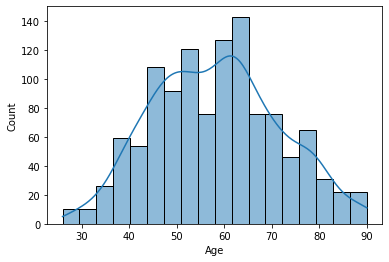

In [57]:
#Histogram of the feature "Age" (it has 5 missing values)
sn.histplot(x=X_train.Age, kde=True)

In [58]:
#Mean and Median
print("The mean is: ", X_train.Age.mean(), "\nThe median is: ",X_train.Age.median())

The mean is:  58.324742268041234 
The median is:  58.0


In [59]:
#Use the median to replace missing "Age" values
X_train_MEDIAN = X_train.Age.median()                #It will be used later
X_train.Age.fillna(X_train_MEDIAN,inplace=True)

#Missing values
print("Number of missing values: ", X_train.isna().sum().sum())

Number of missing values:  0


In [60]:
#No missing values anymore

#Let's deal with "Tumour Stage" feature
#The unique values are ['3a' '3c' '2a' '1' '2b' '1a' '2' '4' '1b' '3b' 'X' '3']
#The following substitutions will be applied:
#  - Set X = 0 (primary tumor cannot be assessed) 
#  - Set all the others as 1,2,3
#  - If a letter is present, it will be replaced with as a=1, b=2, c=3 (0 if absent).

#Split the column (number + letter)
Num = X_train["Tumour Stage"].str.split("",expand=True)[1]
Sta = X_train["Tumour Stage"].str.split("",expand=True)[2]
Stage = pd.DataFrame(pd.concat([Num,Sta],axis=1))
Stage.columns=["T_Stage1","T_Stage2"]
Stage

,T_Stage1,T_Stage2
141,2,a
541,3,a
851,2,a
487,2,a
412,0,
...,...,...
1033,2,a
763,2,b
835,2,b
559,1,


In [61]:
#Replace letters with numbers (0 if absent)
i=0
while i<len(Stage) :
    if Stage.iloc[i,0] == "X":
        Stage.iloc[i,0] = 0
    if Stage.iloc[i,1] == "a" :
        Stage.iloc[i,1] = 1
    if Stage.iloc[i,1] == "b" :
        Stage.iloc[i,1] = 2
    if Stage.iloc[i,1] == "c" :
        Stage.iloc[i,1] = 3
    if Stage.iloc[i,1]=="" :
        Stage.iloc[i,1] = 0
    i=i+1
    
#Insert those new columns in the original datasets and remove "Tumour Stage"
X_train = pd.concat([Stage,X_train],axis=1)
X_train.drop(["Tumour Stage"],axis=1,inplace=True)
X_train

,T_Stage1,T_Stage2,Definition,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype,Tumour_info
141,2,1,1,1,3.0,1,79.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,180
541,3,1,1,2,0.0,1,65.0,2.0,2.0,0.0,2.0,1.0,3.0,3.0,222
851,2,1,1,1,3.0,1,53.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,265
487,2,1,1,1,0.0,1,66.0,2.0,0.0,0.0,1.0,1.0,3.0,3.0,212
412,0,0,1,1,1.0,1,43.0,2.0,2.0,0.0,2.0,1.0,3.0,1.0,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,2,1,1,1,3.0,1,47.0,1.0,1.0,2.0,1.0,1.0,3.0,3.0,297
763,2,2,1,1,3.0,4,62.0,2.0,2.0,1.0,2.0,1.0,7.0,4.0,236
835,2,2,1,1,3.0,1,62.0,2.0,2.0,1.0,2.0,1.0,3.0,3.0,265
559,1,0,1,1,1.0,1,35.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,222


In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   T_Stage1           1168 non-null   object 
 1   T_Stage2           1168 non-null   object 
 2   Definition         1168 non-null   int64  
 3   Gender             1168 non-null   int64  
 4   Menopausal Status  1168 non-null   float64
 5   Race               1168 non-null   int64  
 6   Age                1168 non-null   float64
 7   ER                 1168 non-null   float64
 8   PR                 1168 non-null   float64
 9   HER2               1168 non-null   float64
 10  Lymph Node         1168 non-null   float64
 11  Metastasis         1168 non-null   float64
 12  Histological Type  1168 non-null   float64
 13  Subtype            1168 non-null   float64
 14  Tumour_info        1168 non-null   int64  
dtypes: float64(9), int64(4), object(2)
memory usage: 146.0+ KB


In [63]:
#The new features "T_Stage1" and "T_Stage2" are still "object"
#They must be converted into a numeric format
X_train["T_Stage1"] = pd.to_numeric(X_train["T_Stage1"])
X_train["T_Stage2"] = pd.to_numeric(X_train["T_Stage2"])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   T_Stage1           1168 non-null   int64  
 1   T_Stage2           1168 non-null   int64  
 2   Definition         1168 non-null   int64  
 3   Gender             1168 non-null   int64  
 4   Menopausal Status  1168 non-null   float64
 5   Race               1168 non-null   int64  
 6   Age                1168 non-null   float64
 7   ER                 1168 non-null   float64
 8   PR                 1168 non-null   float64
 9   HER2               1168 non-null   float64
 10  Lymph Node         1168 non-null   float64
 11  Metastasis         1168 non-null   float64
 12  Histological Type  1168 non-null   float64
 13  Subtype            1168 non-null   float64
 14  Tumour_info        1168 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 146.0 KB


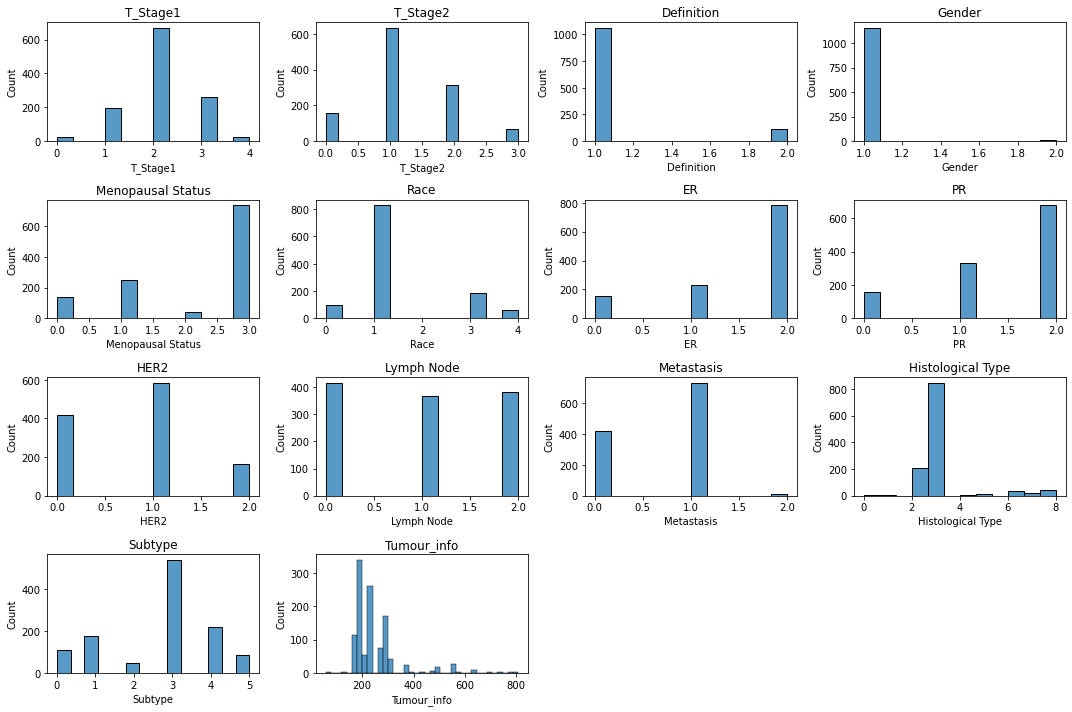

In [64]:
#Now the dataset is complete with 964 entries in 15 columns




#Data distribution for categorical features
plt.figure(figsize=(15,10))
j=1
for i in ["T_Stage1","T_Stage2","Definition","Gender","Menopausal Status","Race","ER","PR",
          "HER2","Lymph Node","Metastasis","Histological Type","Subtype","Tumour_info"] :
    plt.subplot(4,4,j)
    sn.histplot(x = X_train[i])
    plt.title(i)
    j=j+1

plt.tight_layout()

In [65]:
#The feature "Gender" is very unbalanced
X_train.Gender.value_counts()

1    1155
2      13
Name: Gender, dtype: int64

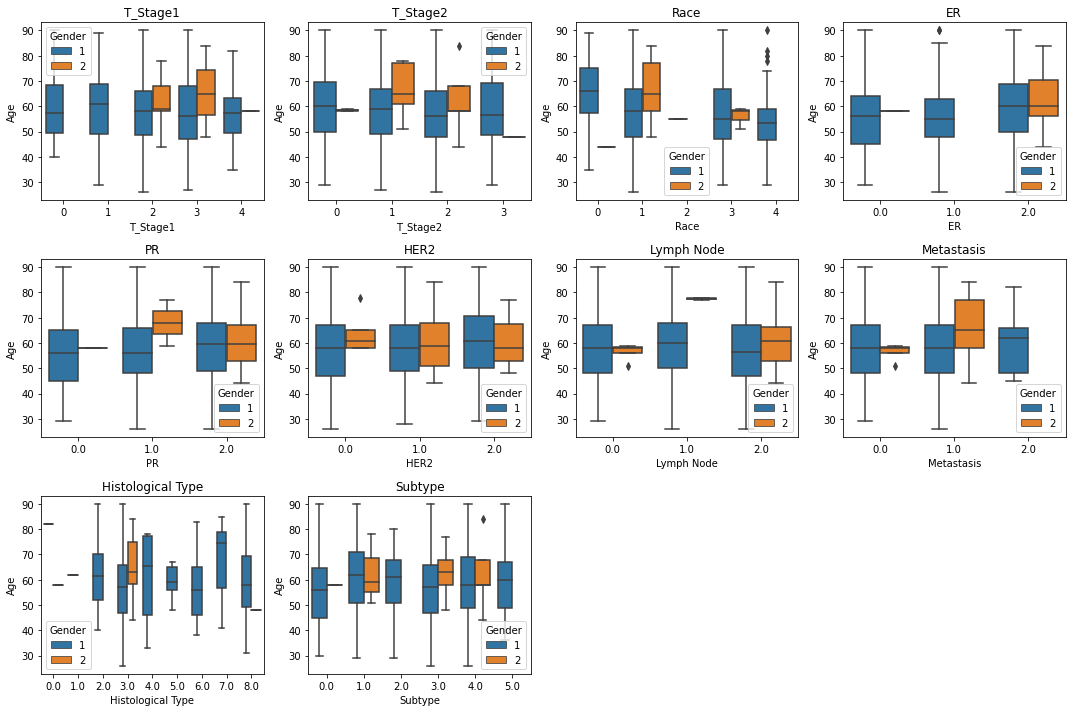

In [66]:
#There are only 8 males that may be trated as generic patient (in this way, the column "Gender" must be removed).
#To check that possibility, let's take a look at their values compared to the female ones

plt.figure(figsize=(15,10))
j=1
for i in ["T_Stage1","T_Stage2","Race","ER","PR","HER2",
          "Lymph Node","Metastasis","Histological Type","Subtype"] :
    plt.subplot(3,4,j)
    sn.boxplot(data = X_train, x = i, y = "Age", hue = "Gender")
    plt.title(i)
    j=j+1
    
plt.tight_layout()

<AxesSubplot:xlabel='Age', ylabel='Count'>

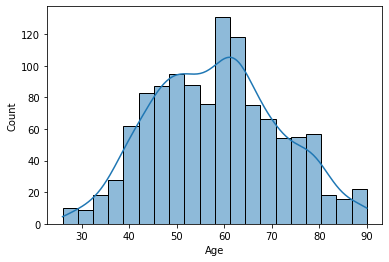

In [67]:
#There are no particular patterns or values for male patients
#As suggested above, one possibility is to treat those male patient as generic patient and drop "Gender".
#For now, let's leave everything as it is


#Data distributions for "Age" (numeric feature)
sn.histplot(x = X_train.Age, bins=20, kde=True)

In [68]:
#The distribution might contain some outliers (at both tails)
#Let's check taht using the z-score and a limit of 3
print("The number of outliers in 'Age' is: {}".format(sum(abs((X_train.Age-X_train.Age.mean())/(X_train.Age.std()))>=3)))

The number of outliers in 'Age' is: 0


In [69]:
#No ouliers

#Target variable "Survival Status"
100*y_train.value_counts()/len(y_train)

alive       84.160959
deceased    15.839041
Name: Survival Status, dtype: float64

In [70]:
#It is a little bit unbalanced and that must be kept into account later.
#In the training session, a weighted classification will be performeced
#(i.e. each model will give more importance to the less frequent class)

#Strings to numbers
y_train.replace(["alive","deceased"],[1,0],inplace=True)

In [71]:
X_train.describe()

,T_Stage1,T_Stage2,Definition,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype,Tumour_info
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,2.051370,1.247432,1.092466,1.011130,2.175514,1.384418,58.323630,1.537671,1.445205,0.783390,0.970890,0.650685,3.173801,2.714041,249.392123
std,0.735277,0.751743,0.289806,0.104956,1.140897,1.008276,13.247938,0.716044,0.719715,0.672764,0.827448,0.499768,1.283245,1.367542,99.432729
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,48.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,184.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,58.000000,2.000000,2.000000,1.000000,1.000000,1.000000,3.000000,3.000000,222.000000
75%,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,67.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,4.000000,291.000000
max,4.000000,3.000000,2.000000,2.000000,3.000000,4.000000,90.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000,5.000000,808.000000


In [72]:
#Let's scale each feature of the entire dataset using MinMaxScaler

#Tranfform "Age" values using MinMaxScaler (i.e. reduce values between 0 and 1)
Set_scaler = MinMaxScaler()                                      #It will be used later
Set_scaler.fit(X_train) 
X_train = pd.DataFrame(Set_scaler.transform(X_train),columns=X_train.columns)
X_train

,T_Stage1,T_Stage2,Definition,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype,Tumour_info
0,0.50,0.333333,0.0,0.0,1.000000,0.25,0.828125,1.0,1.0,0.5,0.5,0.5,0.250,0.2,0.162667
1,0.75,0.333333,0.0,1.0,0.000000,0.25,0.609375,1.0,1.0,0.0,1.0,0.5,0.375,0.6,0.218667
2,0.50,0.333333,0.0,0.0,1.000000,0.25,0.421875,0.5,1.0,0.5,0.5,0.5,0.375,0.6,0.276000
3,0.50,0.333333,0.0,0.0,0.000000,0.25,0.625000,1.0,0.0,0.0,0.5,0.5,0.375,0.6,0.205333
4,0.00,0.000000,0.0,0.0,0.333333,0.25,0.265625,1.0,1.0,0.0,1.0,0.5,0.375,0.2,0.185333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,0.50,0.333333,0.0,0.0,1.000000,0.25,0.328125,0.5,0.5,1.0,0.5,0.5,0.375,0.6,0.318667
1164,0.50,0.666667,0.0,0.0,1.000000,1.00,0.562500,1.0,1.0,0.5,1.0,0.5,0.875,0.8,0.237333
1165,0.50,0.666667,0.0,0.0,1.000000,0.25,0.562500,1.0,1.0,0.5,1.0,0.5,0.375,0.6,0.276000
1166,0.25,0.000000,0.0,0.0,0.333333,0.25,0.140625,0.5,0.5,0.5,0.5,0.5,0.375,0.6,0.218667


In [73]:
#Feature selection
#P-value
Pval = pd.DataFrame(f_classif(X_train,y_train)[1],index=X_train.columns, columns=["P-value"])
Pval.iloc[np.where(Pval>0.05)[0]]

,P-value
Gender,0.418930
Race,0.468885
Lymph Node,0.351957
Metastasis,0.132738
Histological Type,0.054011


In [74]:
#Those features have a p-value larger than 0.05
#Let's drop them from the dataset
Pval_005 = Pval.iloc[np.where(Pval>0.05)[0]].index
X_train.drop(Pval_005,axis=1,inplace=True)

.

.

## **3. Data transformation function**

In [75]:
#All the procedures and transformations above will be used on the Test set before applying the final model
#They will be included in the following function in the same order

def Data_transformation(X,y) :
    #(1) Find the TSS code
    X["Tumour_info"] = X["Patient ID"].str.split("-",expand=True).iloc[:,1]
    X.drop(["Patient ID"],axis=1, inplace=True)
    
    #(2) Categorical data
    X["Definition"].replace(['primary solid tumor','solid tissue normal'],[1,2], inplace=True) 
    X["Gender"].replace(['female','male'],[1,2], inplace=True)
    X["Menopausal Status"].replace(['postmenopausal','perimenopausal','premenopausal','not available',
                                      'unknown','not evaluated','indeterminate'],[3,2,1,0,0,0,0], inplace=True)
    X["Race"].replace(['white','american indian or alaska native','black or african american','asian','not reported'],[1,2,3,4,0], inplace=True)
    X["ER"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
    X["PR"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
    X["HER2"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
    X["Lymph Node"].replace(['present','absent'],[2,1], inplace=True)
    X["Metastasis"].replace(['present','absent'],[2,1], inplace=True)
    X["Histological Type"].replace(['infiltrating carcinoma nos','infiltrating lobular carcinoma','infiltrating ductal carcinoma',
                                      'medullary carcinoma','metaplastic carcinoma','mixed histology','mucinous carcinoma',
                                      'other','not available'],[1,2,3,4,5,6,7,8,0], inplace=True)
    X["Subtype"].replace(['Basal','Her2','LumA','LumB','Normal'],[1,2,3,4,5], inplace=True)
    X["Tumour_info"].replace(TSS,np.arange(1,len(TSS)+1), inplace=True)

    #Missing values
    X["Tumour Stage"].fillna("0",inplace=True)         
    X["Menopausal Status"].fillna(0,inplace=True)
    X["ER"].fillna(0,inplace=True)
    X["PR"].fillna(0,inplace=True)
    X["HER2"].fillna(0,inplace=True)
    X["Lymph Node"].fillna(0,inplace=True)
    X["Metastasis"].fillna(0,inplace=True)
    X["Histological Type"].fillna(0,inplace=True)
    X["Subtype"].fillna(0,inplace=True)

    #(3) Missing Age values
    X.Age.fillna(X_train_MEDIAN,inplace=True)

    #(4) Tumour Stage
    Num = X["Tumour Stage"].str.split("",expand=True)[1]
    Sta = X["Tumour Stage"].str.split("",expand=True)[2]
    Stage = pd.DataFrame(pd.concat([Num,Sta],axis=1))
    Stage.columns=["T_Stage1","T_Stage2"]
    i=0
    while i<len(Stage) :
        if Stage.iloc[i,0] == "X":
            Stage.iloc[i,0] = 0
        if Stage.iloc[i,1] == "a" :
            Stage.iloc[i,1] = 1
        if Stage.iloc[i,1] == "b" :
            Stage.iloc[i,1] = 2
        if Stage.iloc[i,1] == "c" :
            Stage.iloc[i,1] = 3
        if Stage.iloc[i,1]=="" :
            Stage.iloc[i,1] = 0
        i=i+1
    X = pd.concat([Stage,X],axis=1)
    X.drop(["Tumour Stage"],axis=1,inplace=True)
    X["T_Stage1"] = pd.to_numeric(X["T_Stage1"])
    X["T_Stage2"] = pd.to_numeric(X["T_Stage2"])
    
    #(5) Scaling features
    X = pd.DataFrame(Set_scaler.transform(X),columns=X.columns)
    
    #(6) Drop non-significant features
    X.drop(Pval_005,axis=1,inplace=True)
    
    #(7) Target variable
    y.replace(["alive","deceased"],[1,0],inplace=True)
    y = pd.Series(np.array(y))
    
    return X, y

.

.


## **4. Training: first models**

In [76]:
#Creation of a Training set (to train models) and a Validation set (to understand the goodness of the models).
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, 
                                                            test_size = 0.2, 
                                                            random_state = 0, shuffle=True)

In [77]:
#Several models will be applied on the Training set to predict the variable "SalePrice".
#A stratified k-fold cross-valiation method will be used to evaluate each model mean score (preserving the target class proportion)
#The training and validation set will be splitted as 80-20% of the original dataset, respectively.

CV = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

Iterations = 10
Model_log2_acc,Model_tree2_acc,Model_ran2_acc,Model_xgb2_acc,Model_svm2_acc = 0,0,0,0,0
Model_log2_pre,Model_tree2_pre,Model_ran2_pre,Model_xgb2_pre,Model_svm2_pre = 0,0,0,0,0
Model_log2_rec,Model_tree2_rec,Model_ran2_rec,Model_xgb2_rec,Model_svm2_rec = 0,0,0,0,0
Model_log2_f1,Model_tree2_f1,Model_ran2_f1,Model_xgb2_f1,Model_svm2_f1 = 0,0,0,0,0

for i in range(Iterations) :
    print(f'\rProcess (%): {100*(i)/(Iterations)}', end='')       #Counter (%)
    #LOGISTIC REGRESSION
    Model_log = LogisticRegression(class_weight = "balanced")     #To give more importance to the less frequent class
    Model_log2_acc = Model_log2_acc + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_log2_pre = Model_log2_pre + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_log2_rec = Model_log2_rec + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()      
    Model_log2_f1 = Model_log2_f1 + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()

    #DECISION TREE
    Model_tree = DecisionTreeClassifier(class_weight = "balanced", random_state = 0)
    Model_tree2_acc = Model_tree2_acc + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_tree2_pre = Model_tree2_pre + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_tree2_rec = Model_tree2_rec + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_tree2_f1 = Model_tree2_f1 + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()

    #RANDOM FOREST
    Model_ran = RandomForestClassifier(class_weight = "balanced", random_state = 0)
    Model_ran2_acc = Model_ran2_acc + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_ran2_pre = Model_ran2_pre + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_ran2_rec = Model_ran2_rec + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()      
    Model_ran2_f1 = Model_ran2_f1 + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()

    #XGBOOST
    Model_xgb = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, scale_pos_weight = (y_train_t==0).sum()/(y_train_t==1).sum(), seed=0)    #ratio neg/pos
    Model_xgb2_acc = Model_xgb2_acc + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_xgb2_pre = Model_xgb2_pre + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_xgb2_rec = Model_xgb2_rec + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()      
    Model_xgb2_f1 = Model_xgb2_f1 + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()

    #SVM
    Model_svm = svm.SVC(class_weight = "balanced")
    Model_svm2_acc = Model_svm2_acc + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_svm2_pre = Model_svm2_pre + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_svm2_rec = Model_svm2_rec + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_svm2_f1 = Model_svm2_f1 + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()


#Final results
Data_res = {"Mean_accuracy" : [Model_log2_acc/Iterations,Model_tree2_acc/Iterations,Model_ran2_acc/Iterations,Model_xgb2_acc/Iterations,Model_svm2_acc/Iterations],
        "Mean_Precision" : [Model_log2_pre/Iterations,Model_tree2_pre/Iterations,Model_ran2_pre/Iterations,Model_xgb2_pre/Iterations,Model_svm2_pre/Iterations],
        "Mean_Recall" : [Model_log2_rec/Iterations,Model_tree2_rec/Iterations,Model_ran2_rec/Iterations,Model_xgb2_rec/Iterations,Model_svm2_rec/Iterations],
        "Mean_F1_score" : [Model_log2_f1/Iterations,Model_tree2_f1/Iterations,Model_ran2_f1/Iterations,Model_xgb2_f1/Iterations,Model_svm2_f1/Iterations]
       }

Results = pd.DataFrame(data = Data_res, 
                       index = ["Logistic", "DecisionTree","RandomForest","XGBoost","SVM"]).sort_values(by="Mean_accuracy",ascending=False)
Results

Process (%): 90.0

,Mean_accuracy,Mean_Precision,Mean_Recall,Mean_F1_score
RandomForest,0.861883,0.881232,0.968514,0.922615
XGBoost,0.837243,0.910111,0.897882,0.903479
DecisionTree,0.826531,0.889046,0.909187,0.898985
SVM,0.743022,0.919664,0.765425,0.834595
Logistic,0.693767,0.909340,0.711209,0.797464


.

.

## **5. Training: hyperparameters tuning**

In [78]:
#The best models are RandomForest and XGBoost.

#Hyperparameters tuning
#The scoring metric will be the accuracy (i.e. the final model must be good for predicting "alive" and "deceased" patient)
#Hyperameters grid
Params_xgb = {"n_estimators":[100,200], "max_depth":[2,3,4], "reg_lambda":[2,3,5],"reg_alpha":[0.1,0.3],"eval_metric":["logloss"], "scale_pos_weight":[(y_train_t==0).sum()/(y_train_t==1).sum()], "seed": [0]}
Params_ran = {"n_estimators":[100,200], "max_depth":[2,3,4], "min_samples_split":[3,5],"min_samples_leaf":[3,5,8],"class_weight":["balanced"], "random_state": [0]}

#Grid search with a 5-fold cross-validation method
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_xgb = GridSearchCV(Model_xgb, cv = CV, param_grid = Params_xgb, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_xgb2 = Grid_xgb.fit(X_train_t, y_train_t)
print("XGBoost model: done!")
Grid_ran = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_ran2 = Grid_ran.fit(X_train_t, y_train_t)
print("RandomForest model: done!")

print("\n\nThe best XGBoost Regression model is: ",Grid_xgb2.best_params_)
print("The best Random Forest Regression model is: ",Grid_ran2.best_params_)
print("\nThe best XGBoost Regression Accuracy is: ",Grid_xgb2.best_score_)
print("The best Random Forest Regression Accuracy is: ",Grid_ran2.best_score_)

XGBoost model: done!
RandomForest model: done!


The best XGBoost Regression model is:  {'eval_metric': 'logloss', 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 2, 'scale_pos_weight': 0.17780580075662042, 'seed': 0}
The best Random Forest Regression model is:  {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'random_state': 0}

The best XGBoost Regression Accuracy is:  0.8362198838479673
The best Random Forest Regression Accuracy is:  0.8222873900293255


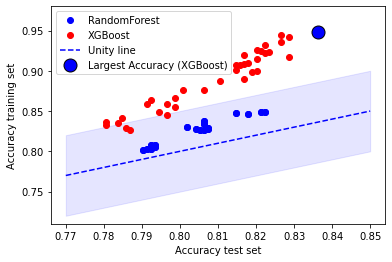

In [79]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(Grid_ran2.cv_results_["mean_test_score"]),pd.Series(Grid_ran2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(Grid_xgb2.cv_results_["mean_test_score"]),pd.Series(Grid_xgb2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot([0.77,0.85],[0.77,0.85],'--b')
plt.fill_between([0.77,0.85],[0.82,0.90],[0.72,0.80],color='blue',alpha=0.1, label="_nolegend_")
plt.plot(B.Test[np.argmax(B.Test)],B.Train[np.argmax(B.Test)],'bo',markersize=13,mec="black")
plt.ylim([0.71,0.98])
plt.xlabel("Accuracy test set")
plt.ylabel("Accuracy training set")
plt.legend(["RandomForest","XGBoost","Unity line","Largest Accuracy (XGBoost)"], loc="upper left")

In [80]:
#XGBoost is overfitting the data while the RandomForest does not.

#Let's tune RandomForest Hyperparameters further
#Hyperparameter grid
Params_ran = {"n_estimators":[300], "max_depth":[3,4,5], "min_samples_split":[2,3,4],"min_samples_leaf":[2,3,4],"class_weight":["balanced"], "max_features":["sqrt", "log2"], "random_state":[0]}

#Grid search with a 5-fold cross-validation method
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_ran22 = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_ran222 = Grid_ran22.fit(X_train_t, y_train_t)

print("\nThe best RandomForest Regression Accuracy is: ",Grid_ran222.best_params_)
print("The best Random Forest Regression Accuracy is: ",Grid_ran222.best_score_)


The best RandomForest Regression Accuracy is:  {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 0}
The best Random Forest Regression Accuracy is:  0.8469093209131161


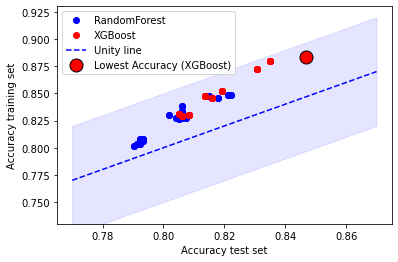

In [81]:
#The accuracy is larger (even larger than the previous XGBoost one)

#Training vs. Validation accuracy
A = pd.concat([pd.Series(Grid_ran2.cv_results_["mean_test_score"]),pd.Series(Grid_ran2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(Grid_ran222.cv_results_["mean_test_score"]),pd.Series(Grid_ran222.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot([0.77,0.87],[0.77,0.87],'--b')
plt.fill_between([0.77,0.87],[0.82,0.92],[0.72,0.82],color='blue',alpha=0.1,label="_nolegend_")
plt.plot(B.Test[np.argmax(B.Test)],B.Train[np.argmax(B.Test)],'ro',markersize=13,mec="black")
plt.ylim([0.73,0.93])
plt.xlabel("Accuracy test set")
plt.ylabel("Accuracy training set")
plt.legend(["RandomForest","XGBoost","Unity line","Lowest Accuracy (XGBoost)"], loc="upper left")

In [82]:
#Still in the shaded region therefore no strong overfit

#Accuracy on training and test set
Model1 = RandomForestClassifier(**Grid_ran222.best_params_)
Model11 = Model1.fit(X_train_t,y_train_t)

Final_accuracy_tr = (Model11.predict(X_train_t) == y_train_t).sum()/len(y_train_t)
Final_accuracy_te = (Model11.predict(X_test_t) == y_test_t).sum()/len(y_test_t)
print("The Accuracy on the Training set is:  {:.2f}% (AUC: {:.2f})".format(100*Final_accuracy_tr, roc_auc_score(y_train_t,Model11.predict(X_train_t))))
print("The Accuracy on the Test set is:  {:.2f}% (AUC: {:.2f})".format(100*Final_accuracy_te,roc_auc_score(y_train_t,Model11.predict(X_train_t))))

The Accuracy on the Training set is:  87.26% (AUC: 0.81)
The Accuracy on the Test set is:  83.76% (AUC: 0.81)


In [83]:
#Test and Training accuracy are similar

#Confusion matrix
Conf_matrix = confusion_matrix(y_test_t, Model1.predict(X_test_t))
print("Precision: {:.2f}".format(precision_score(y_test_t, Model1.predict(X_test_t))))
print("Recall: {:.2f}".format(recall_score(y_test_t, Model1.predict(X_test_t))))
print("F1-score: {:.2f}\n".format(f1_score(y_test_t, Model1.predict(X_test_t))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

Precision: 0.90
Recall: 0.90
F1-score: 0.90



,Predicted_Dead,Predicted_Alive
Actual_Dead,25,19
Actual_Alive,19,171


.

.

## **6. Model finalization**

In [84]:
#Finalization of the model
#Final training on the whole dataset
Model1 = RandomForestClassifier(**Grid_ran222.best_params_)
Best_model = Model1.fit(X_train, y_train)

#Final accuracy on the whole Training set
Final_accuracy = (Best_model.predict(X_train) == y_train).sum()/len(y_train)
print("The final Accuracy on the whole Training set is:  {:.2f}% (AUC: {:.2f})".format(100*Final_accuracy,roc_auc_score(y_train,Model11.predict(X_train))))

The final Accuracy on the whole Training set is:  86.64% (AUC: 0.79)


In [85]:
#Confusion matrix
Conf_matrix = confusion_matrix(y_train, Best_model.predict(X_train))
print("Precision: {:.2f}".format(precision_score(y_train, Best_model.predict(X_train))))
print("Recall: {:.2f}".format(recall_score(y_train, Best_model.predict(X_train))))
print("F1-score: {:.2f}\n".format(f1_score(y_train, Best_model.predict(X_train))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

Precision: 0.94
Recall: 0.90
F1-score: 0.92



,Predicted_Dead,Predicted_Alive
Actual_Dead,132,53
Actual_Alive,103,880


.

.


## **7. Test on unseen data**

In [86]:
#Preparation of the Test set using the the function defined previously
X_test, y_test = Data_transformation(X_test,y_test)

In [87]:
#Accuracy on the Test set (using the function "Final_Model_predict(X)"
Final_accuracy_test = (Best_model.predict(X_test) == y_test).sum()/len(y_test)
print("The accuracy on the unseen Test set is:  {:.2f}%".format(100*Final_accuracy_test))

The accuracy on the unseen Test set is:  81.08%


In [88]:
#Confusion matrix
Conf_matrix = confusion_matrix(y_test, Best_model.predict(X_test))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

,Predicted_Dead,Predicted_Alive
Actual_Dead,9,2
Actual_Alive,5,21
